## Upcoming simulation strategy optimizations ##

The list of phase 2 survey strategy variations include 

### Retro (comparison): ###
* Classic ‘traditional’ survey footprint and v2.0 settings - a halfway point between the classic footprint and the updated variations in the new simulations. Standard ‘traditional’ survey footprint used in baselines from v1.5 to 1.7.1, 2x15s visits in grizy and 1x30s in u band, 2-band rolling cadence in WFD
* Classic ‘traditional’ v1.5-v1.7.1 survey footprint and v1.7.1 settings. This run would be directly comparable to baseline_nexp2_v1.7.1_10yrs, but run with the newest version of the simulator. Standard ‘traditional’ survey footprint used in baselines from v1.5 to 1.7.1, 2x15s visits in all bands, no rolling cadence.

### Rolling Cadence: ###
* No rolling cadence anywhere (in comparison to the 2-band rolling cadence in the baseline). 
* 2-band rolling cadence at 50% strength
* 2-band rolling cadence at 90% strength 
* 3-band rolling cadence at 50% strength
* 3-band rolling cadence at 90% strength
* 6-band rolling cadence at 50% strength
* 6-band rolling cadence at 90% strength
* A stretch goal of 2-band rolling cadence in the low-dust extinction area, and 6-band rolling in the bulge area
Note that in each of these rolling cadence simulations ‘2-band’ is referring to the fraction of the sky which is ‘active’ in rolling at any time. 2-band means ½ of the sky is rolling; 3-band means ⅓ of the sky is rolling. In each of these cases, the active sky area is further split into a North and South region, to better manage alert follow-up. 

### Longer u-band visits: ###
* Longer u-band visit time, and approximately the same number of visits in u as in the baseline. This requires more survey time to be spent on u band, so a few % of time is removed from other bandpasses (altering the filter balance slightly). 
* Longer u-band visit time, but the same relative amount of survey time. This reduces the number of visits in u band accordingly.

### More blue band visits: ###
* Increase the fraction of visits in g from 9% to 12%, while keeping u at ~ 7%.
* Increase the fraction of visits in g from 9% to 11% and increase u to ~ 8%.


### NES visits: ###
* Approximately 200 visits per pointing in the NES
* Approximately 300 visits per pointing in the NES
* Approximately 500 visits per pointing in the NES

### GP visits:  ###
* Approximately 180 visits per pointing in the non-bulge GP
* Approximately 350 visits per pointing in the non-bulge GP

### Deep Drilling fraction: ###
* 3% time for DDF
* 8% time for DDF
* 2 of the DDFs will be chosen to roll on/off on alternating years 
* DDF visits acquired with AGN cadence 
* DDF visits acquired with DESC cadence 
* Stretch goal: DDFs where one field (COSMOS) is observed more heavily. COSMOS is at a different RA range than the other DDFs and may be more easily observable with a larger fraction of time 

### Presto Color: ###
* Triplets are obtained for all visits in only the first year, before rolling cadence starts in the low-dust-extinction WFD. This would enable variability template generation early in the survey. 
* Triplets are obtained for approximately 10% of the time in all years
* Triplets are obtained for approximately 20% of the time in all years
* Triplets are obtained for approximately 30% of the time in all years

### Long Gaps: ###
* Variable visit spacing between 2-14 hours after year 5 for 100% of visits
* Variable visit spacing between 2-14 hours after year 5 for 50% of visits
* Triplets are obtained approximately 10% of the time in all years, with intervals between 2-14 hours
* Triplets are obtained approximately 20% of the time in all years, with intervals between 2-14 hours

### Micro-surveys: ###
* Short twilight visits for near-Sun objects incl. NEOs (similar to the twilight_NEO family in v1.7, as per the Schwamb et al Cadence Note)
* ToO follow-up to identify optical counterparts of gravitational wave sources 
* Mini-survey of Roman microlensing bulge field
* Addition of a northern stripe with a limited number of visits in ugrizy from the upper limit of the survey footprint to Dec=+30
* Single short (5s) exposure survey of the sky in ugrizy in year 1 for static sky calibration
* Multiple short exposures of the sky in ugrizy at a range of times for transient detection and static sky calibration 
* Micro-survey of the Virgo Cluster
* Deeper g-band imaging of 10 local volume galaxies
* High cadence visits of 2 fields in the SMC for microlensing
* All of the micro-surveys 


For some of these simulations, it is easy to set up and modify the Sky_area_generator to meet these goals, so these footprints are demonstrated here. 

In [1]:
import warnings
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

from rubin_sim.scheduler.utils import Sky_area_generator
import rubin_sim.maf as maf

In [2]:
def scalingfunc(survey_frac=None, nvisits_per_pointing=None, area=None):
    # How much survey time .. approximately .. is it likely to take to cover a given area? 
    # We can use a rough scaling derived from 
    # https://github.com/lsst-pst/survey_strategy/blob/master/fbs_1.7/SurveyFootprints-NvisitsVsArea.ipynb
    # x = (scale['NvisitPerPoint*']/825) * (scale['Area']/18000) / (scale['t']/0.77)  == constant (~1)
    defaults = {'survey_frac': 0.77, 'area': 18000, 'nvisits_per_pointing': 825}
    if area is None:
        area = (survey_frac / defaults['survey_frac']) / \
                (nvisits_per_pointing / defaults['nvisits_per_pointing'])
        return area * defaults['area']
    elif nvisits_per_pointing is None:
        nvisits_per_pointing = (survey_frac / defaults['survey_frac']) / (area / defaults['area'])
        return nvisits_per_pointing * defaults['nvisits_per_pointing']
    elif survey_frac is None:
        survey_frac = nvisits_per_pointing / defaults['nvisits_per_pointing'] * area / defaults['area']
        return survey_frac * defaults['survey_frac']
        
def calc_area_time(footprint, nvis_peak=825, nside=64, verbose=False):
    # Given a survey footprint, returns (effective) area in footprint and fraction of survey time required
    eff_area = footprint.sum() * hp.nside2pixarea(nside, degrees=True)
    nvis_srd_min = 750 * 1.08
    srd_area = (len(footprint[np.where(footprint * nvis_peak > nvis_srd_min)])
                * hp.nside2pixarea(nside, degrees=True))
    # survey time required? 
    time = scalingfunc(nvisits_per_pointing=nvis_peak, area=eff_area)
    if (verbose):
        print(f'Effective area in footprint {eff_area}')
        print(f'Area in footprint which can contribute to SRD {srd_area}')
        print(f'Approximate fraction of survey time required for footprint {time}')
    return eff_area, srd_area, time

def plot_sky(skymap, plotDict=None, slicer=maf.HealpixSlicer(64)):
    # This just makes it easier to make sure these footprint maps match MAF
    plotFunc = maf.HealpixSkyMap()
    t = ma.MaskedArray(data=np.array(skymap, float), mask=np.where(skymap > 0, 0, 1))
    if plotDict is None:
        # Just because of how the slicer works, this cannot be None
        plotDict = {'colorMin': None}
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        plotFunc(t, slicer, plotDict)
    
def plot_footprints(sky):
    colorMax = np.percentile(sky.total, 98) * 1.2
    plot_sky(sky.total, plotDict={'title':  'All filters', 'colorMax': colorMax, 'figsize': (8, 6)})
    for f in sky.filterlist:
        colorMax = np.percentile(sky.total_perfilter[f], 98) * 1.2
        plot_sky(sky.total_perfilter[f], plotDict={'title': f'Filter {f}', 'colorMax': colorMax, 'figsize': (8, 6)})

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Baseline ## 

In [3]:
baseline = Sky_area_generator(nside=64)
baseline.set_maps(ddf=True)
baseline.combine_maps()
area, srd_area, subscription = calc_area_time(baseline.total/baseline.nvis['dustfree'], baseline.nvis['dustfree'])
print(f'Quick estimate of overall survey subscription {subscription}')
print(f'With about {srd_area} anticipated above SRD minimum nvisits')

Quick estimate of overall survey subscription 1.008908161016707
With about 18655.819145753816 anticipated above SRD minimum nvisits


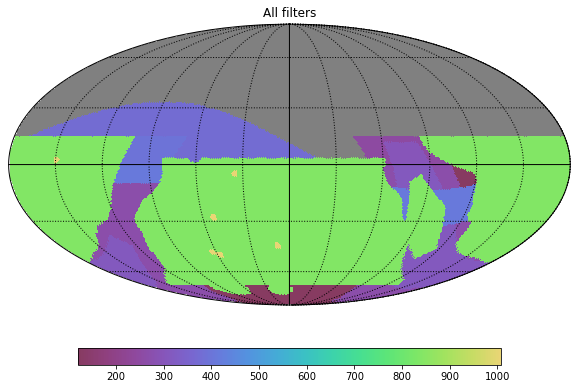

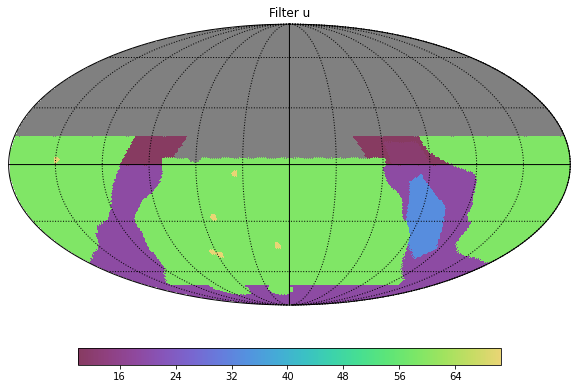

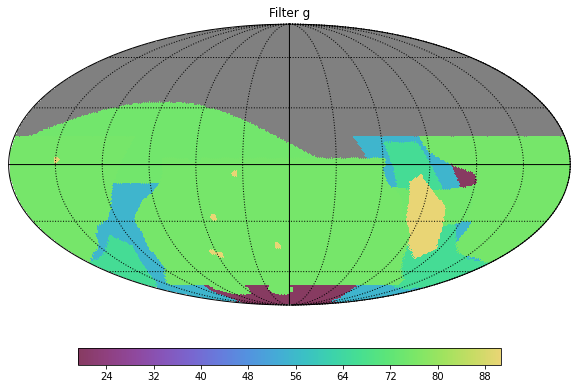

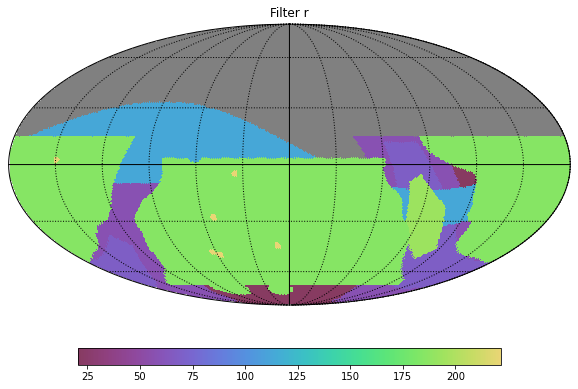

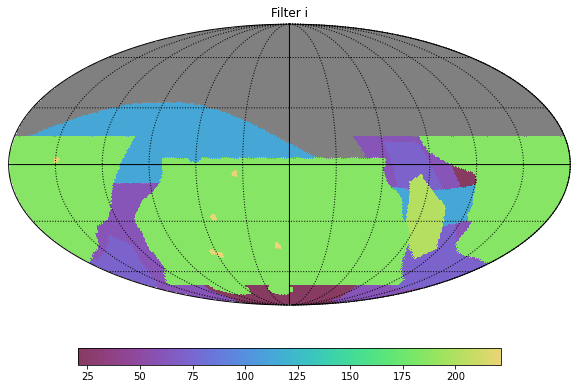

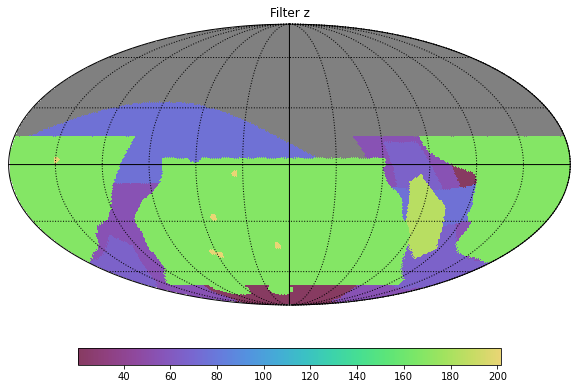

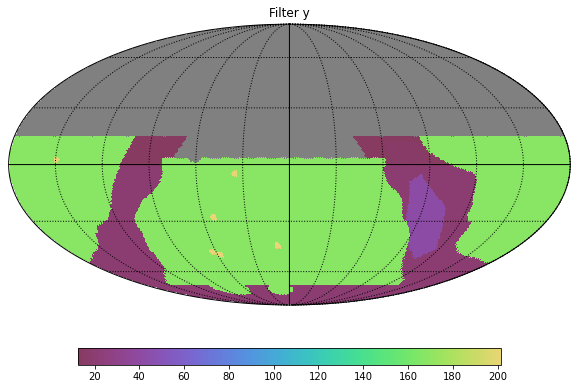

In [4]:
plot_footprints(baseline)

## NES variations ##

In the baseline, the NES has 375 visits,while the WFD regions have 840 (0.44642857142857145)
In the variations, the NES has approximately [0.5  0.75 1.25] * baseline visits ([187. 281. 468.])

For the simulation with 0.5 of the baseline visits in the NES (187.0)
Quick estimate of overall survey subscription 0.9737860782038161
With about 18655.819145753816 anticipated above SRD minimum nvisits

For the simulation with 0.75 of the baseline visits in the NES (281.0)
Quick estimate of overall survey subscription 0.9901541308370855
With about 18655.819145753816 anticipated above SRD minimum nvisits

For the simulation with 1.25 of the baseline visits in the NES (468.0)
Quick estimate of overall survey subscription 1.0327672836962818
With about 18655.819145753816 anticipated above SRD minimum nvisits



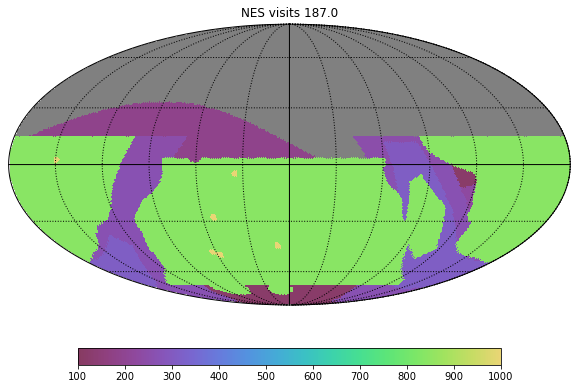

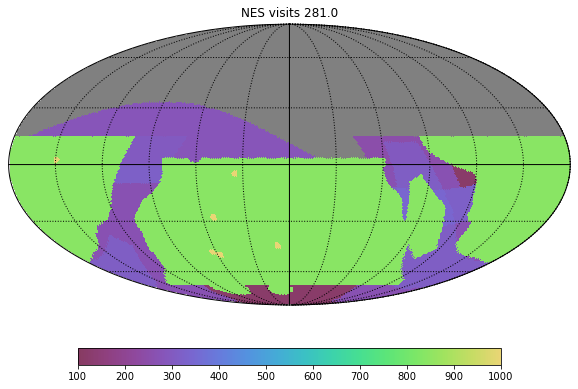

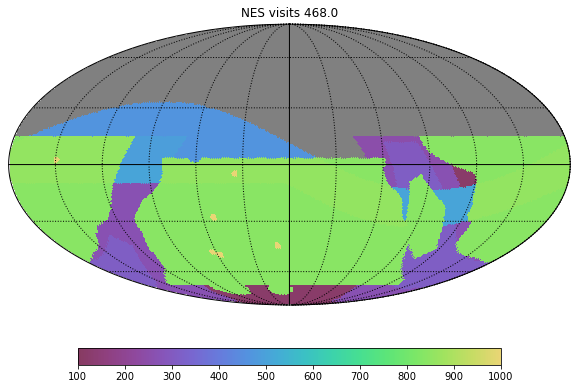

In [5]:
variations = np.array([0.5, 0.75, 1.25], float)
print(f"In the baseline, the NES has {baseline.nvis['nes']} visits,"
      f"while the WFD regions have {baseline.nvis['dustfree']} ({baseline.nvis['nes']/baseline.nvis['dustfree']})")
print(f"In the variations, the NES has approximately {variations} * baseline visits "
      f"({np.floor(baseline.nvis['nes']*variations)})")
print()

for frac, nvis_nes in zip(variations, np.floor(variations * baseline.nvis['nes'])):
    nes = Sky_area_generator()
    nes.set_maps(nes=False, ddf=True)
    nes._set_nes(nvis_nes=nvis_nes)
    nes.combine_maps()
    area, srd_area, subscription = calc_area_time(nes.total/nes.nvis['dustfree'], nes.nvis['dustfree'])
    print(f"For the simulation with {frac} of the baseline visits in the NES ({nes.nvis['nes']})")
    print(f'Quick estimate of overall survey subscription {subscription}')
    print(f'With about {srd_area} anticipated above SRD minimum nvisits')
    plot_sky(nes.total, {'figsize': (8,6), 'colorMin': 100, 'colorMax': 1000, 
                         'title': f"NES visits {nes.nvis['nes']}"})
    print()

## Galactic plane background (non-bulge) variations ##

This is slightly trickier because we don't want to vary the number of visits per pointing in the bulge, but rather the background galactic plane. Further, in the baseline, this is split into two regions -- there is the high-visit bulge, a larger diamond 'background bulge' region which has about 300 visits per pointing, and the remainder of the plane which has 250 visits per pointing.  This results in a ratio of about 850:300:250 (goal), or 1:.35:.29. 

For the variations, we keep the 0.83 ratio between the 'background bulge' and the 'rest of the galactic plane'. 

In the baseline, the background portion of the galactic plane has between 249.0 to 300  visits while the WFD regions have 840 (0.35714285714285715)
In the variations, the gal has approximately [0.65 1.3 ] * baseline visits ([195. 390.])

For the simulation with 0.65 of the baseline visits in the background galactic plane (195.0)
Quick estimate of overall survey subscription 0.9901669306247042
With about 18655.819145753816 anticipated above SRD minimum nvisits

For the simulation with 1.3 of the baseline visits in the background galactic plane (390.0)
Quick estimate of overall survey subscription 1.0247245333164892
With about 18650.78338388255 anticipated above SRD minimum nvisits



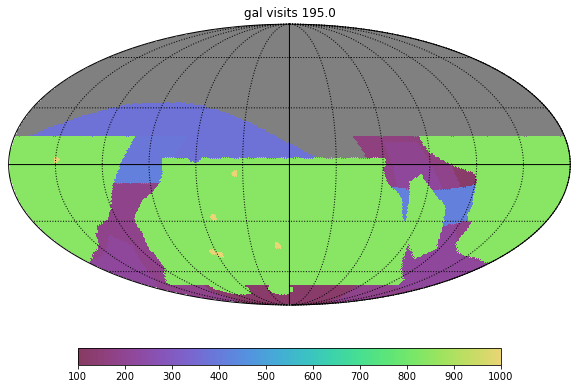

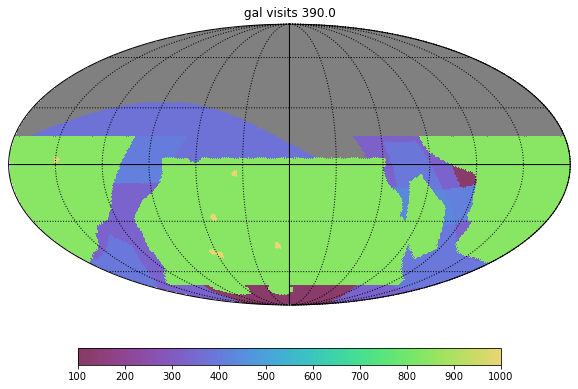

In [6]:
baseline_gal_B = 300
variations = np.array([0.65, 1.3], float)
print(f"In the baseline, the background portion of the galactic plane "
      f"has between {baseline_gal_B * 0.83} to {baseline_gal_B}  visits",
      f"while the WFD regions have {baseline.nvis['dustfree']} ({baseline_gal_B/baseline.nvis['dustfree']})")
print(f"In the variations, the gal has approximately {variations} * baseline visits "
      f"({np.floor(baseline_gal_B*variations)})")
print()

for frac, nvis_gal in zip(variations, np.floor(variations * baseline_gal_B)):
    gal = Sky_area_generator()
    gal.set_maps(gp=False, ddf=True)
    gal._set_galactic_plane(nvis_gal_A=baseline.nvis['gal'], 
                            nvis_gal_B=nvis_gal, nvis_gal_min=np.floor(nvis_gal * 0.83))
    gal.combine_maps()
    area, srd_area, subscription = calc_area_time(gal.total/gal.nvis['dustfree'], gal.nvis['dustfree'])
    print(f"For the simulation with {frac} of the baseline visits in the background galactic plane ({nvis_gal})")
    print(f'Quick estimate of overall survey subscription {subscription}')
    print(f'With about {srd_area} anticipated above SRD minimum nvisits')
    plot_sky(gal.total, {'figsize': (8,6), 'colorMin': 100, 'colorMax': 1000, 
                         'title': f"gal visits {nvis_gal}"})
    print()

## Retro ##

In [7]:
from rubin_sim.scheduler.utils import standard_goals
footprints_hp = standard_goals(nside=64)
standard_total = np.zeros(hp.nside2npix(64), float)
for f in footprints_hp:
    standard_total += footprints_hp[f]
    #plot_sky(footprints_hp[f])
standard_total = standard_total / standard_total.max() * 825

In [8]:
flat_filter_balance = {'u': 0.16, 'g': 0.16, 'r': 0.16, 'i': 0.16, 'z': 0.16, 'y': 0.16}
nes_filter_balance = {'u': 0, 'g': 0.2, 'r': 0.46, 'i': 0.46, 'z': 0.4, 'y': 0}
wfd_filter_balance = {'u': 0.31, 'g':0.44, 'r':1.0, 'i':1.0, 'z':0.9, 'y':0.9}

retro = Sky_area_generator()
retro.read_dustmap()
nvis_wfd = 825
retro._set_dustfree_wfd(nvis_wfd, dec_min=-62, dec_max=3.6, dust_limit=100000000, adjust_halves=0)
retro._set_nes(nvis_wfd * 0.33, eclat_min=-30, eclat_max=10, eclip_dec_min=3.6, dec_cutoff=3.6,
               nes_filter_balance=nes_filter_balance)
retro._set_galactic_plane(nvis_wfd*0.17, nvis_gal_B=0, nvis_gal_min=0, dec_max=35,
                          center_width_A=10, end_width_A=4, gal_long1_A=290, gal_long2_A=70,
                         gal_filter_balance=flat_filter_balance)
retro._set_scp(nvis_wfd*0.17, dec_max=-62, scp_filter_balance=flat_filter_balance)
retro._set_magellanic_clouds(nvis_mcs=0)
#retro._set_ddf()
gal_mask = np.where(retro.maps['gal'] > 0)[0]
retro.maps['dustfree'][gal_mask] = 0
for f in retro.filterlist:
    retro.maps_perfilter['dustfree'][f][gal_mask] = 0
retro.combine_maps(trim_overlap=False)


area, srd_area, subscription = calc_area_time(retro.total/retro.nvis['dustfree'], retro.nvis['dustfree'])
print(f'Quick estimate of overall survey subscription {subscription}')
print(f'With about {srd_area} anticipated above SRD minimum nvisits')

Quick estimate of overall survey subscription 0.8626492089091347
With about 18196.725521823308 anticipated above SRD minimum nvisits


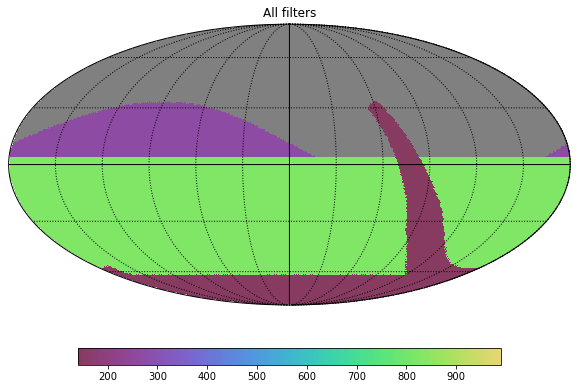

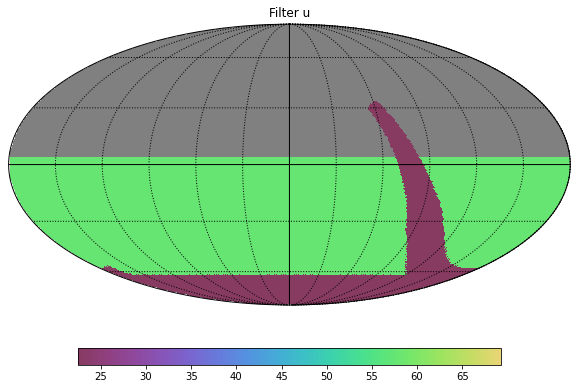

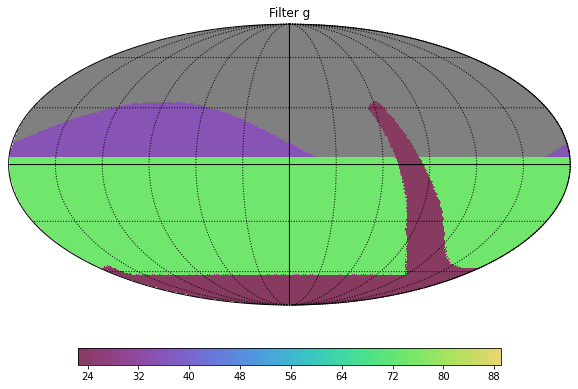

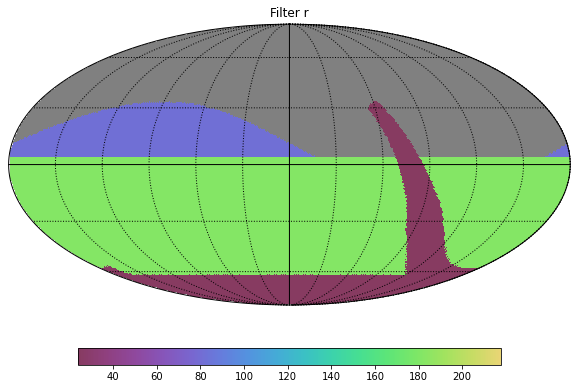

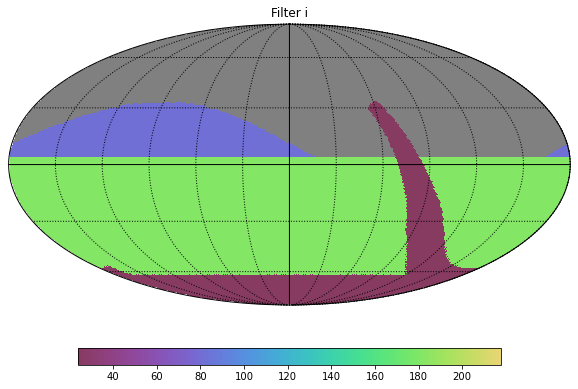

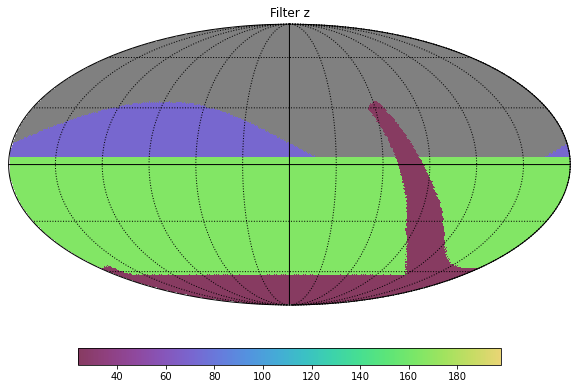

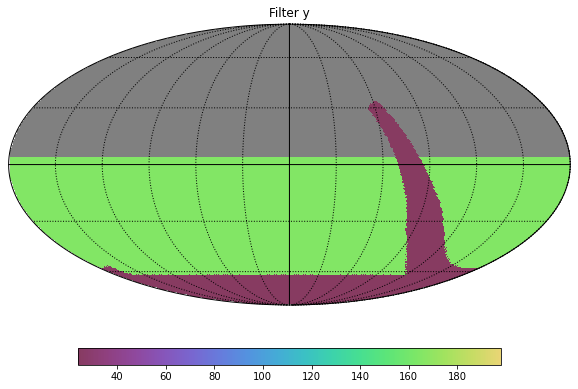

In [9]:
plot_footprints(retro)